In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import matplotlib.pylab as pylab
import cartopy.feature as cfeature
from endgame import hist2d
import scipy.stats as stats
import xarray as xr
import ipdb
import glob
import itertools
import numpy.ma as ma
from utils import u_statistics as u_stat
from scipy.stats import gaussian_kde
import pickle as pkl
from utils import u_plot as uplot, u_darrays
import pandas as pd
from scipy.stats import gaussian_kde, linregress
import matplotlib.cm as cm
from utils import u_met
import seaborn
import metpy
from metpy import calc
from metpy.units import units
import statsmodels.api as sm
from scipy import ndimage
import matplotlib.patches as patches
import io
import xarray as xr

from numpy.polynomial import polynomial as P

##for regridding, install xesmf:
# conda install esmpy
# pip install xesmf
from utils import constants as cnst

pylab.rcParams['figure.figsize'] = (40., 40.)
%matplotlib inline

In [1]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


In [3]:
import matplotlib.patches as patches
def draw_map(ax, t, lat, lon, title='', levels=None, quiver=None, contour=None, clabel='', cmap='RdBu_r'):
   
    plt.contourf(lon, lat, t, transform=ccrs.PlateCarree(), cmap=cmap, levels=levels, extend='both')
    ax.coastlines()

    ## quiver list
    if quiver is not None:
        qu = ax.quiver(quiver['x'], quiver['y'], quiver['u'], quiver['v'],scale=quiver['scale'],width=0.0005, headwidth=7)
    
    
        ## additional contour on plot   
    if contour is not None:
        contours = ax.contour(contour['x'], contour['y'], contour['data'], levels=contour['levels'], colors='Turquoise', linewidths=0.5 )
        #plt.clabel(contours, inline=True, fontsize=7, fmt='%1.1f')
    
    # Gridlines
    xl = ax.gridlines(draw_labels=True);
    xl.top_labels = False
    xl.right_labels = False
    xl.xlines = False
    xl.ylines=False
    # Countries
    ax.add_feature(cartopy.feature.BORDERS, linestyle='--', color='grey');
    
    #rect2 = patches.Rectangle((box[0],box[2]),box[1]-box[0],box[3]-box[2],linewidth=0.8,edgecolor='w',facecolor='none', zorder=99)
        
    #ax.add_patch(rect2)
    
    plt.title(title)
    cbar = plt.colorbar()
    cbar.set_label(clabel)

In [4]:
MREGIONS = {
 'GPlains_N' : [[-100,-90,32,47], 'nam', -6, (1,7), (8,12), (1,12), [-99,-96,42,44], 'GPlains', 'JJA', [5,6,7,8,9]], # # 18
 'GPlains_S' : [[-100,-90,32,47], 'nam', -6, (1,7), (8,12), (1,12), [-98,-95,36,39], 'GPlains', 'JJA', [5,6,7,8,9]], # # 18
 'china_W' : [[105,115,25,40], 'asia', 8 , (1,7), (8,12), (1,12), [105,107,29,31], 'china', 'JJA', [5,6,7,8,9]], # 4
 'china_E' : [[105,115,25,40], 'asia', 8 , (1,7), (8,12), (1,12), [111,113,25,27], 'china', 'JJA', [5,6,7,8,9]], # 4
 'india_N' : [[70,90, 5,30], 'asia', 5, (1,7), (8,12), (1,12), [74,76,24,26], 'india', 'JJA', [5,6,7,8,9]], # 7
 'india_S' : [[70,90, 5,30], 'asia', 5, (1,7), (8,12), (1,12), [76,79,18,21], 'india', 'JJA', [5,6,7,8,9]], # 7
 'WAf_N' : [[-18,25,4,25], 'spac', 0, (1,7), (8,12), (1,12), [-5,5,14,16], 'WAf', 'JJA', [5,6,7,8,9]], # last is hourly offset to UCT # 12    # [-18,25,4,25]
 'WAf_S' : [[-18,25,4,25], 'spac', 0, (1,7), (8,12), (1,12), [-5,5,7,9], 'WAf', 'JJA', [5,6,7,8,9]],
 'australia_S' : [[120,140,-27, -15], 'asia', 9, (10,12), (1,5), (1,12), [125,134, -21,-18], 'australia', 'DJF', [11,12,1,2,3]], # 3
 'australia_N' : [[120,140,-27, -15], 'asia', 9, (10,12), (1,5), (1,12), [125,134, -17,-15], 'australia', 'DJF', [11,12,1,2,3]],
 'SAf' : [[20,35, -35,-15], 'spac', 2, (9,12), (1,5), (1,12), [21,24.5,-28,-24], 'SAf', 'DJF', [11,12,1,2,3]], # 10
 'sub_SA_S' : [[-68,-47, -40, -20.5], 'spac', -4, (9,12), (1,5), (1,12), [-63,-60,-33,-30], 'sub_SA', 'DJF', [11,12,1,2,3]],  # 16
 'sub_SA_N' : [[-68,-47, -40, -20.5], 'spac', -4, (9,12), (1,5), (1,12), [-63,-60,-28,-22], 'sub_SA', 'DJF', [11,12,1,2,3]]  # 16
# 'trop_SA' : [[-75, -50, -20, -5], 'spac', -5, (1,12), (1,12), (1,12)], # 17

}
S_REGION = 'china_W'
REGION = MREGIONS[S_REGION][7]

In [5]:
#era5f_pl = xr.open_mfdataset('/media/ck/LStorage/global_water/ERA5_global_0.7/monthly/pressure_levels/*.nc')
era5f_pl = xr.open_mfdataset(glob.glob('/media/ck/LStorage/global_water/ERA5_global_0.7/monthly/pressure_levels/*.nc'))
era5f_pl = u_darrays.flip_lat(era5f_pl)

In [6]:
#era5f_pl = xr.open_mfdataset('/media/ck/LStorage/global_water/ERA5_global_0.7/monthly/pressure_levels/*.nc')
era5f_srfc = xr.open_mfdataset(glob.glob('/media/ck/LStorage/global_water/ERA5_global_0.7/monthly/surface/*.nc')[0:5])
era5f_srfc = u_darrays.flip_lat(era5f_srfc)

In [7]:
era5u_mean = era5f_pl['u'].groupby('time.month').mean('time').load()
era5v_mean = era5f_pl['v'].groupby('time.month').mean('time').load()

In [8]:
era_uh = era5f_pl['u'].sel(level=650).groupby('time.month').mean('time').load()
era_ul = era5f_pl['u'].sel(level=925).groupby('time.month').mean('time').load()
era_vh = era5f_pl['v'].sel(level=650).groupby('time.month').mean('time').load()
era_vl = era5f_pl['v'].sel(level=925).groupby('time.month').mean('time').load()
era_t = era5f_pl['t'].sel(level=925).groupby('time.month').mean('time').load()
era_gh = era5f_pl['z'].sel(level=650).groupby('time.month').mean('time').load()
era_gl = era5f_pl['z'].sel(level=925).groupby('time.month').mean('time').load()

era_ushear = era_uh-era_ul
era_vshear = era_vh-era_vl
era_shear = np.sqrt(era_ushear**2+era_vshear**2)
era_thick = era_gh - era_gl

In [11]:
np.mean(era_thick)

<xarray.DataArray 'z' ()>
array(27601.557, dtype=float32)

In [9]:
sh = era5f_srfc['sshf'].groupby('time.month').mean('time').load()/3600/-30
t2 = era5f_srfc['t2m'].groupby('time.month').mean('time').load()
lh = era5f_srfc['slhf'].groupby('time.month').mean('time').load()/3600/-30

Text(0.5, 1.0, 'Rainy season (DJF or JJA) | r =0.52| slope=7371.31 m s$^{-1}$ / K deg$^{-1}$')

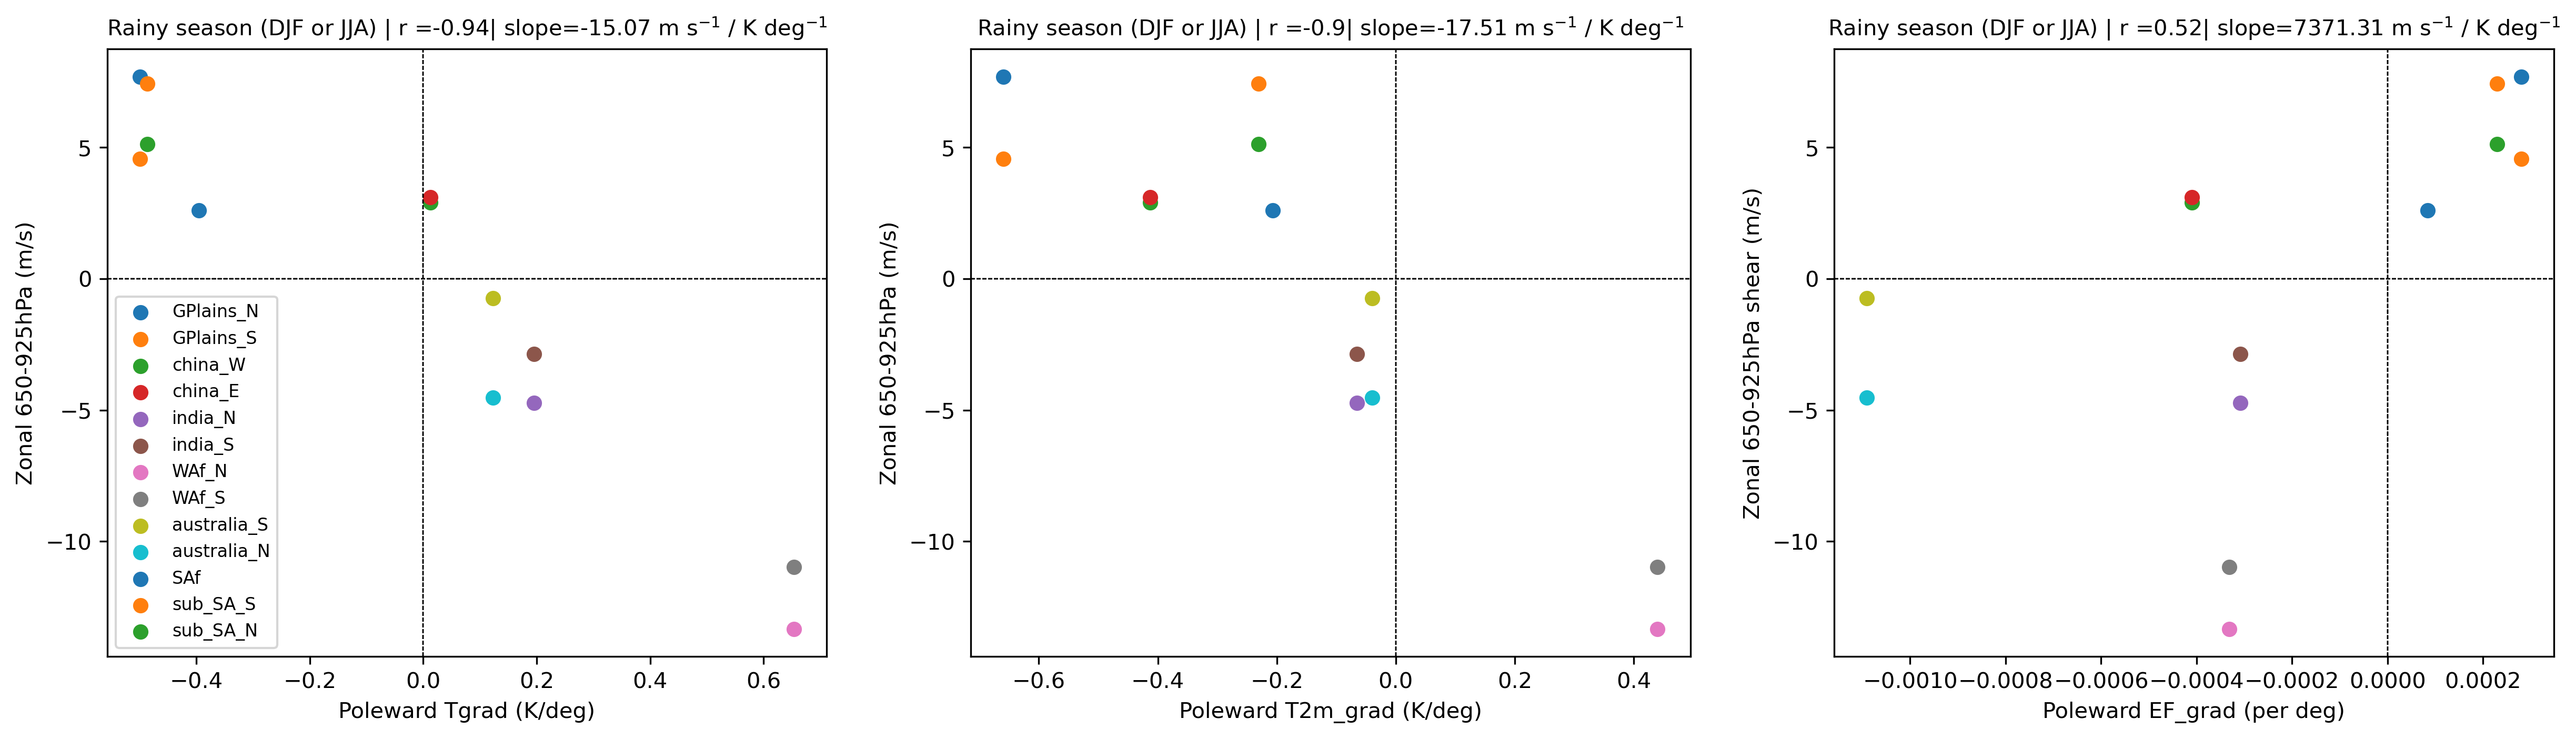

In [10]:
f = plt.figure(figsize=(20,5), dpi=300)


colors = ['red', 'orange', 'gold', 'brown', 'blue', 'purple', 'violet']
lss = ['solid', 'solid', 'solid', 'solid', 'dashed', 'dashed', 'dashed']

# for idx, seas in enumerate(['MAM', 'JJA', 'SON', 'DJF']):

tgrad_list = []
shear_list = []
ax = f.add_subplot(131)
for ids, reg in enumerate((list(MREGIONS.keys()))):
    
        

        seas = MREGIONS[reg][9]

        box = MREGIONS[reg][6]
        lbox = MREGIONS[reg][0]

        erashear_box = era_ushear.sel(month=era_ushear.month.isin(seas), latitude=slice(box[2],box[3]), longitude=slice(box[0],box[1])).mean(['month','longitude','latitude']).squeeze()
        erat_poly = era_t.sel(month=era_t.month.isin(seas), latitude=slice(lbox[2],lbox[3]), longitude=slice(lbox[0],lbox[1])).mean(['month','longitude']).squeeze().polyfit(dim='latitude', deg=1)
        
        if ids >= 8:
            erat_poly = erat_poly*-1

#         if ids >= 8:
#             erashear_box = erashear_box*-1
        
        ax.scatter(erat_poly['polyfit_coefficients'][0], erashear_box, label=reg)
        plt.title('Rainy season per region (DJF or JJA)', fontsize=10)
        ax.set_xlabel('Poleward Tgrad (K/deg)')
        ax.set_ylabel('Zonal 650-925hPa (m/s)')
        ax.axhline(0, color='k', linestyle='dashed', linewidth=0.5)
        ax.axvline(0, color='k', linestyle='dashed', linewidth=0.5)
        tgrad_list.append(erat_poly['polyfit_coefficients'][0].values)
        shear_list.append(erashear_box.values)
pf, intercept, rval, p, std_err = stats.linregress(tgrad_list, shear_list)
plt.title('Rainy season (DJF or JJA) | r ='+ str(np.round(rval,2))+'| slope='+str(np.round(pf,2))+' m s$^{-1}$ / K deg$^{-1}$', fontsize=10)  
ax.legend(loc='lower left', fontsize=8)


tgrad_list = []
shear_list = []
ax = f.add_subplot(132)
for ids, reg in enumerate((list(MREGIONS.keys()))):
    
        

        seas = MREGIONS[reg][9]

        box = MREGIONS[reg][6]
        lbox = MREGIONS[reg][0]

        erashear_box = era_ushear.sel(month=era_ushear.month.isin(seas), latitude=slice(box[2],box[3]), longitude=slice(box[0],box[1])).mean(['month','longitude','latitude']).squeeze()
        erat_poly = t2.sel(month=t2.month.isin(seas), latitude=slice(lbox[2],lbox[3]), longitude=slice(lbox[0],lbox[1])).mean(['month','longitude']).squeeze().polyfit(dim='latitude', deg=1)
        
        if ids >= 8:
            erat_poly = erat_poly*-1
#         if ids >= 8:
#             erashear_box = erashear_box*-1
        
        ax.scatter(erat_poly['polyfit_coefficients'][0], erashear_box, label=reg)
        plt.title('Rainy season per region (DJF or JJA)', fontsize=10)
        ax.set_xlabel('Poleward T2m_grad (K/deg)')
        ax.set_ylabel('Zonal 650-925hPa (m/s)')
        ax.axhline(0, color='k', linestyle='dashed', linewidth=0.5)
        ax.axvline(0, color='k', linestyle='dashed', linewidth=0.5)
        tgrad_list.append(erat_poly['polyfit_coefficients'][0].values)
        shear_list.append(erashear_box.values)
pf, intercept, rval, p, std_err = stats.linregress(tgrad_list, shear_list)
plt.title('Rainy season (DJF or JJA) | r ='+ str(np.round(rval,2))+'| slope='+str(np.round(pf,2))+' m s$^{-1}$ / K deg$^{-1}$', fontsize=10)     


tgrad_list = []
shear_list = []
ax = f.add_subplot(133)
for ids, reg in enumerate((list(MREGIONS.keys()))):
    
        

        seas = MREGIONS[reg][9]

        box = MREGIONS[reg][6]
        lbox = MREGIONS[reg][0]

        erashear_box = era_ushear.sel(month=era_ushear.month.isin(seas), latitude=slice(box[2],box[3]), longitude=slice(box[0],box[1])).mean(['month','longitude','latitude']).squeeze()
        era_shbox = sh.sel(month=sh.month.isin(seas), latitude=slice(lbox[2],lbox[3]), longitude=slice(lbox[0],lbox[1])).mean(['month','longitude']).squeeze()*-1/3600     #.polyfit(dim='latitude', deg=1)
        era_lhbox = lh.sel(month=lh.month.isin(seas), latitude=slice(lbox[2],lbox[3]), longitude=slice(lbox[0],lbox[1])).mean(['month','longitude']).squeeze()*-1/3600
        
        erat_poly = ((era_lhbox)/(era_lhbox+era_shbox)).polyfit(dim='latitude', deg=1)
        erat_poly = era_shbox.polyfit(dim='latitude', deg=1)
        
        #ipdb.set_trace()
        
        if ids >= 8:
            erat_poly = erat_poly*-1
            
#         if ids >= 8:
#             erashear_box = erashear_box*-1
        
        ax.scatter(erat_poly['polyfit_coefficients'][0], erashear_box, label=reg)
        plt.title('Rainy season per region (DJF or JJA)', fontsize=10)
        ax.set_xlabel('Poleward EF_grad (per deg)')
        ax.set_ylabel('Zonal 650-925hPa shear (m/s)')
        ax.axhline(0, color='k', linestyle='dashed', linewidth=0.5)
        ax.axvline(0, color='k', linestyle='dashed', linewidth=0.5)
        tgrad_list.append(erat_poly['polyfit_coefficients'][0].values)
        shear_list.append(erashear_box.values)
pf, intercept, rval, p, std_err = stats.linregress(tgrad_list, shear_list)
plt.title('Rainy season (DJF or JJA) | r ='+ str(np.round(rval,2))+'| slope='+str(np.round(pf,2))+' m s$^{-1}$ / K deg$^{-1}$', fontsize=10)  


#f.savefig(cnst.FIGS+'/LMCS/ERA5_shear_profiles/shear_Tgradient_relationship_climMean_wStats.jpg')

In [13]:
MMREGIONS = {
 'GPlains' : [[-100,-90,32,47], 'nam', -6, (1,7), (5,9), (1,12)], # # 18  
 'china' : [[105,115,25,40], 'asia', 8 , (1,7), (5,9), (1,12)], # 4
 'india' : [[70,90, 5,30], 'asia', 5, (1,7), (5,9), (1,12)], # 7
 'WAf' : [[-18,25,4,25], 'spac', 0, (1,7), (5,9), (1,12)], # last is hourly offset to UCT # 12    # [-18,25,4,25]
 'australia' : [[120,140,-23, -11], 'asia', 9, (11,3), (11,3), (1,12)], # 3
 'SAf' : [[20,35, -35,-15], 'spac', 2, (9,12), (11,3), (11,3)], # 10
 'sub_SA' : [[-68,-47, -40, -20.5], 'spac', -4, (11,3), (11,3), (1,12)] , # 16
# 'trop_SA' : [[-75, -50, -20, -5], 'spac', -5, (1,12), (1,12), (1,12)], # 17


}

In [14]:
rdics = {}
for regs in MMREGIONS.keys():
    for ids, y in enumerate(range(2000,2021)):
        #'ipdb.set_trace()
        try:
            test = pd.read_csv(glob.glob('/media/ck/LStorage/global_water/ERA5_MCS_saveFiles/trackv2/'+regs+'_ERA5_10LT_2000-2019_MCSTRACK_localBulk*_'+str(y)+'*_FullYear.csv')[0])
        except:
            ipdb.set_trace()
#         test = pd.read_csv(glob.glob('/media/ck/LStorage/global_water/save_files_v2/'+regs+'_mcs_tracks_final_'+str(y)+'*.csv')[0])
        if ids == 0:
            test2 = pd.DataFrame(test)
        else :
            test2 = pd.concat([test2, test])
    rdics[regs] = test2

In [15]:
for ids, regs in enumerate(MMREGIONS.keys()):
    
    months = MMREGIONS[regs][4]
    dat = rdics[regs]

#     if ids>=4: 
#         posi = (dat['era_precip'] < 0.1) # & (((dat['direction']>=180) & (dat['ushear100m_650']>0)) | ((dat['direction']<=180) & (dat['ushear100m_650']<0)))# & ((dat['utc_month']>=months[0]) | (dat['utc_month']<=months[1]))
#     else:
#         posi = (dat['era_precip'] < 0.1)# & (((dat['direction']>=180) & (dat['ushear100m_650']>0)) | ((dat['direction']<=180) & (dat['ushear100m_650']<0)))#  & ((dat['utc_month']>=months[0]) & (dat['utc_month']<=months[1])) 
#     if ids>=4: 
#         posi = (dat['era_precip'] < 0.1)  & ((dat['utc_month']>=months[0]) | (dat['utc_month']<=months[1]))
#     else:
#         posi = (dat['era_precip'] < 0.1)  & ((dat['utc_month']>=months[0]) & (dat['utc_month']<=months[1])) 
        
#     dat = dat[posi]
        
#     if ids in [0,1,5,6]: 
#         posi = (dat['era_precip'] < 0.1)  & ((dat['direction']>=180) & (dat['ushear925_650'] >= 0))
#     else:
#         posi = (dat['era_precip'] < 0.1) & ((dat['direction']<=180) & (dat['ushear925_650'] <= 0))  
        
#     dat = dat[posi]
    
    if ids>=4: 
        posi = (dat['era_precip'] < 1)  & ((dat['utc_month']>=months[0]) | (dat['utc_month']<=months[1]))
    else:
        posi = (dat['era_precip'] < 1)  & ((dat['utc_month']>=months[0]) & (dat['utc_month']<=months[1])) 

    rdics[regs] = dat[posi]

In [17]:
from metpy.calc import basic
from metpy.units import units
from metpy.constants import default

In [18]:
f = basic.coriolis_parameter(10 * units.degrees)

In [19]:
print(list(rdics['WAf'].keys()))

['direction', 'tminlon', 'tminlat', 'tmin_calc', 'tmin', 'tmean_core', 'tmean_ccs', 'tcwv', 'tgrad2m', 'tgrad925', 'smgrad', 'efgrad', 'shgrad', 'lhgrad', 'pmax', 'pmean', 'ptot', 'q925', 'q650', 'q850', 'era_precip', 'sm', 'ef', 'u925', 'u650', 'v925', 'v650', 'w925', 'w650', 'rh925', 'rh650', 't925', 't650', 'div925', 'div850', 'div650', 'pv925', 'pv650', 'ushear925_650', 'ushear850_650', 'ushear925_850', 'ushear100m_650', 'vshear925_650', 'vshear850_650', 'vshear925_850', 'vshear100m_650', 'shear925_650', 'shear850_650', 'shear925_850', 'shear100m_650', 'cape', 't2m', 'track_duration', 'start_status', 'end_status', 'start_basetime', 'end_basetime', 'start_split_cloudnumber', 'end_merge_cloudnumber', 'base_time', 'meanlat', 'meanlon', 'area', 'cloudnumber', 'track_status', 'track_interruptions', 'core_area', 'cold_area', 'corecold_mintb', 'corecold_meantb', 'core_meantb', 'mcs_duration', 'mcs_status', 'ccs_area', 'pf_npf', 'pf_lon1', 'pf_lon2', 'pf_lon3', 'pf_lat1', 'pf_lat2', 'pf_la

In [20]:
default.Cp_d

1004.6662184201462 <Unit('joule / kelvin / kilogram')>

In [21]:
10 / (default.Cp_d * default.rho_d)

0.007804285714285712 <Unit('kelvin * meter ** 3 / joule')>

In [22]:
default.rho_d

1.2753959689401746 <Unit('kilogram / meter ** 3')>

In [23]:
g/f # meters per second

NameError: name 'g' is not defined

In [24]:
0.8 / 111 * 387 / (25+273.15) * 3000  # dt / dz (0.8 K / 111 km) * g/f (in km/s) / mean temperature at location (~25degC) * dz (atmospheric thickness between levels in meters) = m/s shear

28.06495913992141

GPlains_N <xarray.DataArray 'z' ()>
<Quantity(2945.41842, 'second ** 2 / meter')>
GPlains_S <xarray.DataArray 'z' ()>
<Quantity(2970.61277, 'second ** 2 / meter')>
china_W <xarray.DataArray 'z' ()>
<Quantity(2994.11703, 'second ** 2 / meter')>
china_E <xarray.DataArray 'z' ()>
<Quantity(2996.27975, 'second ** 2 / meter')>
india_N <xarray.DataArray 'z' ()>
<Quantity(3020.9523, 'second ** 2 / meter')>
india_S <xarray.DataArray 'z' ()>
<Quantity(3010.92403, 'second ** 2 / meter')>
WAf_N <xarray.DataArray 'z' ()>
<Quantity(3020.45698, 'second ** 2 / meter')>
WAf_S <xarray.DataArray 'z' ()>
<Quantity(2983.29151, 'second ** 2 / meter')>
australia_S <xarray.DataArray 'z' ()>
<Quantity(3008.58227, 'second ** 2 / meter')>
australia_N <xarray.DataArray 'z' ()>
<Quantity(3001.53248, 'second ** 2 / meter')>
SAf <xarray.DataArray 'z' ()>
<Quantity(3002.40541, 'second ** 2 / meter')>
sub_SA_S <xarray.DataArray 'z' ()>
<Quantity(2953.38933, 'second ** 2 / meter')>
sub_SA_N <xarray.DataArray 'z' ()>
<

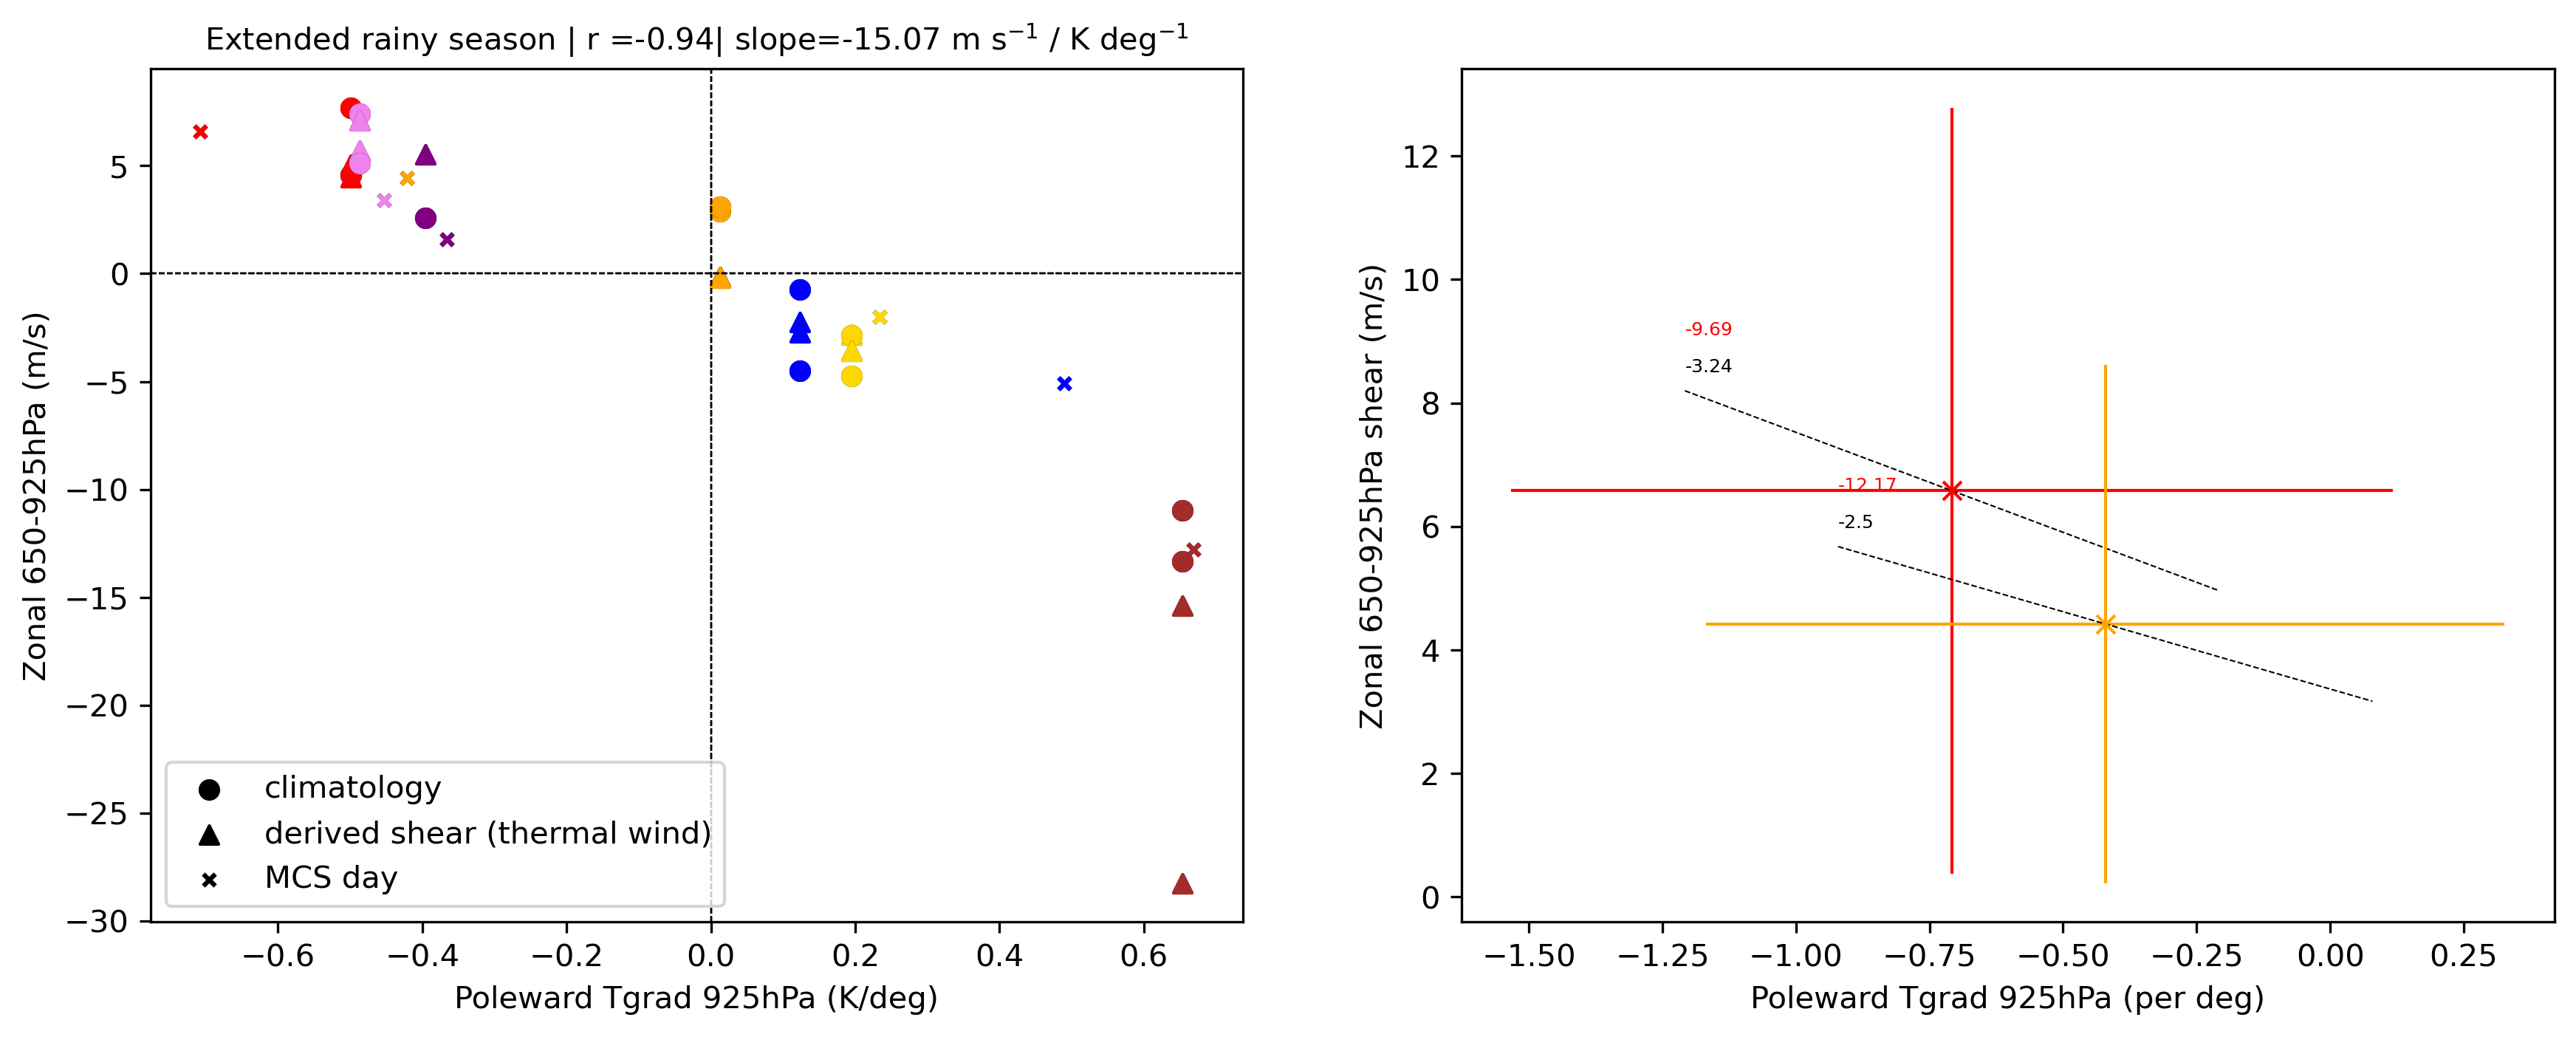

In [29]:
f = plt.figure(figsize=(14,5), dpi=300)

colors = ['red','red', 'orange', 'orange', 'gold', 'gold', 'brown', 'brown', 'blue', 'blue', 'purple','violet', 'violet']
lss = ['solid', 'solid', 'solid', 'solid', 'dashed', 'dashed', 'dashed']

deg = 111 #km

# for idx, seas in enumerate(['MAM', 'JJA', 'SON', 'DJF']):

tgrad_list = []
shear_list = []
ax = f.add_subplot(121)
for ids, reg in enumerate((list(MREGIONS.keys()))):
    
        

        seas = MREGIONS[reg][9]

        box = MREGIONS[reg][6]
        lbox = MREGIONS[reg][0]
        
        lat = np.mean(box[2:4])

        erashear_box = era_ushear.sel(month=era_ushear.month.isin(seas), latitude=slice(box[2],box[3]), longitude=slice(box[0],box[1])).mean(['month','longitude','latitude']).squeeze()
        erathick_box = era_thick.sel(month=era_ushear.month.isin(seas), latitude=slice(box[2],box[3]), longitude=slice(box[0],box[1])).mean(['month','longitude','latitude']).squeeze()
        erathick_box = erathick_box/default.g
        erat_box = era_t.sel(month=era_t.month.isin(seas), latitude=slice(lbox[2],lbox[3]), longitude=slice(lbox[0],lbox[1])).mean(['month','longitude','latitude']).squeeze()
        erat_poly = era_t.sel(month=era_t.month.isin(seas), latitude=slice(lbox[2],lbox[3]), longitude=slice(lbox[0],lbox[1])).mean(['month','longitude']).squeeze().polyfit(dim='latitude', deg=1)
        
        coriolis = basic.coriolis_parameter(lat* units.degrees) # coriolis  du/dz = -(g/f) * dT/dy zonal thermal wind
        rossby_def_radius = (default.g / coriolis)*-1
        
        shear_theoretical = (erat_poly['polyfit_coefficients'][0] / 111 * rossby_def_radius/1000 / erat_box * erathick_box).values
        
        if ids >= 8:
            erat_poly = erat_poly*-1

#         if ids >= 8:
#             erashear_box = erashear_box*-1

        print(reg, erathick_box)
        clim = ax.scatter(erat_poly['polyfit_coefficients'][0], erashear_box, c='k', label='climatology')
        ax.scatter(erat_poly['polyfit_coefficients'][0], erashear_box, label=reg, c=colors[ids])
        #
        
        theory = ax.scatter(erat_poly['polyfit_coefficients'][0], shear_theoretical, c='k', marker='^', label='derived shear (thermal wind)')
        ax.scatter(erat_poly['polyfit_coefficients'][0], shear_theoretical, c=colors[ids], marker='^')
        
        
        plt.title('Rainy season per region (DJF or JJA)', fontsize=10)
        ax.set_xlabel('Poleward Tgrad 925hPa (K/deg)')
        ax.set_ylabel('Zonal 650-925hPa (m/s)')
        ax.axhline(0, color='k', linestyle='dashed', linewidth=0.5)
        ax.axvline(0, color='k', linestyle='dashed', linewidth=0.5)
        tgrad_list.append(erat_poly['polyfit_coefficients'][0].values)
        shear_list.append(erashear_box.values)
pf, intercept, rval, p, std_err = stats.linregress(tgrad_list, shear_list)
plt.title('Extended rainy season | r ='+ str(np.round(rval,2))+'| slope='+str(np.round(pf,2))+' m s$^{-1}$ / K deg$^{-1}$', fontsize=10)  
ax.legend(loc='lower left', fontsize=8)

colors = ['red', 'orange', 'gold', 'brown', 'blue', 'purple', 'violet']
tgrad_list = []
shear_list = []
for ids, regs in enumerate(MMREGIONS.keys()):
    var2 = 'ushear925_650'
    var1 = 'tgrad925'
    
    dat = rdics[regs]
    
    x = dat[var1]
    y = dat[var2]


    if ids >= 4:
        x = x*-1
        
    #ax.set_ylim(-1.5,1.5)
        
    mcs = ax.scatter(np.mean(x), np.mean(y), color='k', marker='x', s=15, label='MCS day')
    ax.scatter(np.mean(x), np.mean(y), color=colors[ids], marker='x', s=15)
    
ax.legend(handles=[clim, theory, mcs])

ax = f.add_subplot(122)
colors = ['red', 'orange', 'gold', 'brown', 'blue', 'purple', 'violet']
tgrad_list = []
shear_list = []
for ids, regs in enumerate(MMREGIONS.keys()):
    var2 = 'ushear925_650'
    var1 = 'tgrad925'
    
    dat = rdics[regs]
    
    x = dat[var1]
    y = dat[var2]
    #ipdb.set_trace()
    #theoretical_y = (x / 111 * rossby_def_radius/1000 / dat['t925'] * erathick_box.values).values
    theoretical_y = []
    for case in np.arange(len(dat['tminlat'])):

        coriolis = basic.coriolis_parameter(dat['tminlat'].values[case]* units.degrees)
        rossby_def_radius = (default.g / coriolis)*-1

        valout = np.array(dat[var1].values[case] / 111 * rossby_def_radius/1000 / dat['t925'].values[case] * erathick_box.values)
        if abs(dat['tminlat'].values[case]) <=12:
            ipdb.set_trace()
        theoretical_y.append(float(valout))
    #mean:
#     coriolis = basic.coriolis_parameter(np.mean(dat['tminlat'])* units.degrees) # coriolis  du/dz = -(g/f) * dT/dy zonal thermal wind
#     rossby_def_radius = (default.g / coriolis)*-1
#     theoretical_y = (np.mean(x) / 111 * rossby_def_radius/1000 / np.mean(dat['t925']) * erathick_box.values)
    #ipdb.set_trace()
    if ids >= 4:
        x = x*-1
        
    #ax.set_ylim(-1.5,1.5)
        
    ax.scatter(np.mean(x), np.mean(y), color=colors[ids], marker='', s=1)
    plt.errorbar(np.mean(x), np.mean(y), yerr=np.std(y), xerr=np.std(x), fmt="x", color=colors[ids], linewidth=1, label=regs)
    pf, intercept, rval, p, std_err = stats.linregress(x, y)
    
    pf_theo, intercept_theo, rval_theo, p_theo, std_err_theo = stats.linregress(x, theoretical_y)
    
    xer = np.arange(np.mean(x)-0.5,np.mean(x)+1) #np.arange(np.percentile(x,0.4), np.percentile(x,0.6))
    yer = intercept+pf*xer
    yer_theo = intercept_theo+pf_theo*xer
    plt.plot(xer, yer, color='k', linestyle='dashed', linewidth=0.5)
    
    #plt.plot(xer,yer_theo, color='r', linestyle='dashed', linewidth=0.5)
    
    
    plt.text(xer[0], yer[0]+0.3, str(np.round(pf,2)), fontsize=6)
    plt.text(xer[0], yer[0]+0.9, str(np.round(pf_theo,2)), fontsize=6, color='r')
    tgrad_list.append(np.mean(x))
    shear_list.append(np.mean(y))
    ax.set_xlabel('Poleward Tgrad 925hPa (per deg)')
    ax.set_ylabel('Zonal 650-925hPa shear (m/s)')
pf, intercept, rval, p, std_err = stats.linregress(tgrad_list, shear_list)
plt.title('Extended rainy season | r ='+ str(np.round(rval,2))+'| slope='+str(np.round(pf,2))+' m s$^{-1}$ / K deg$^{-1}$', fontsize=10)


plt.legend()
#f.savefig('/home/ck/DIR/cornkle/figs/LMCS/CMIP_LS3MIP/ERA5_only/ERA5_scatter_meansVs_MCSdays.png')

GPlains_N <xarray.DataArray 'z' ()>
<Quantity(2945.41842, 'second ** 2 / meter')>
GPlains_S <xarray.DataArray 'z' ()>
<Quantity(2970.61277, 'second ** 2 / meter')>
china_W <xarray.DataArray 'z' ()>
<Quantity(2994.11703, 'second ** 2 / meter')>
china_E <xarray.DataArray 'z' ()>
<Quantity(2996.27975, 'second ** 2 / meter')>
india_N <xarray.DataArray 'z' ()>
<Quantity(3020.9523, 'second ** 2 / meter')>
india_S <xarray.DataArray 'z' ()>
<Quantity(3010.92403, 'second ** 2 / meter')>
WAf_N <xarray.DataArray 'z' ()>
<Quantity(3020.45698, 'second ** 2 / meter')>
WAf_S <xarray.DataArray 'z' ()>
<Quantity(2983.29151, 'second ** 2 / meter')>
australia_S <xarray.DataArray 'z' ()>
<Quantity(3008.58227, 'second ** 2 / meter')>
australia_N <xarray.DataArray 'z' ()>
<Quantity(3001.53248, 'second ** 2 / meter')>
SAf <xarray.DataArray 'z' ()>
<Quantity(3002.40541, 'second ** 2 / meter')>
sub_SA_S <xarray.DataArray 'z' ()>
<Quantity(2953.38933, 'second ** 2 / meter')>
sub_SA_N <xarray.DataArray 'z' ()>
<

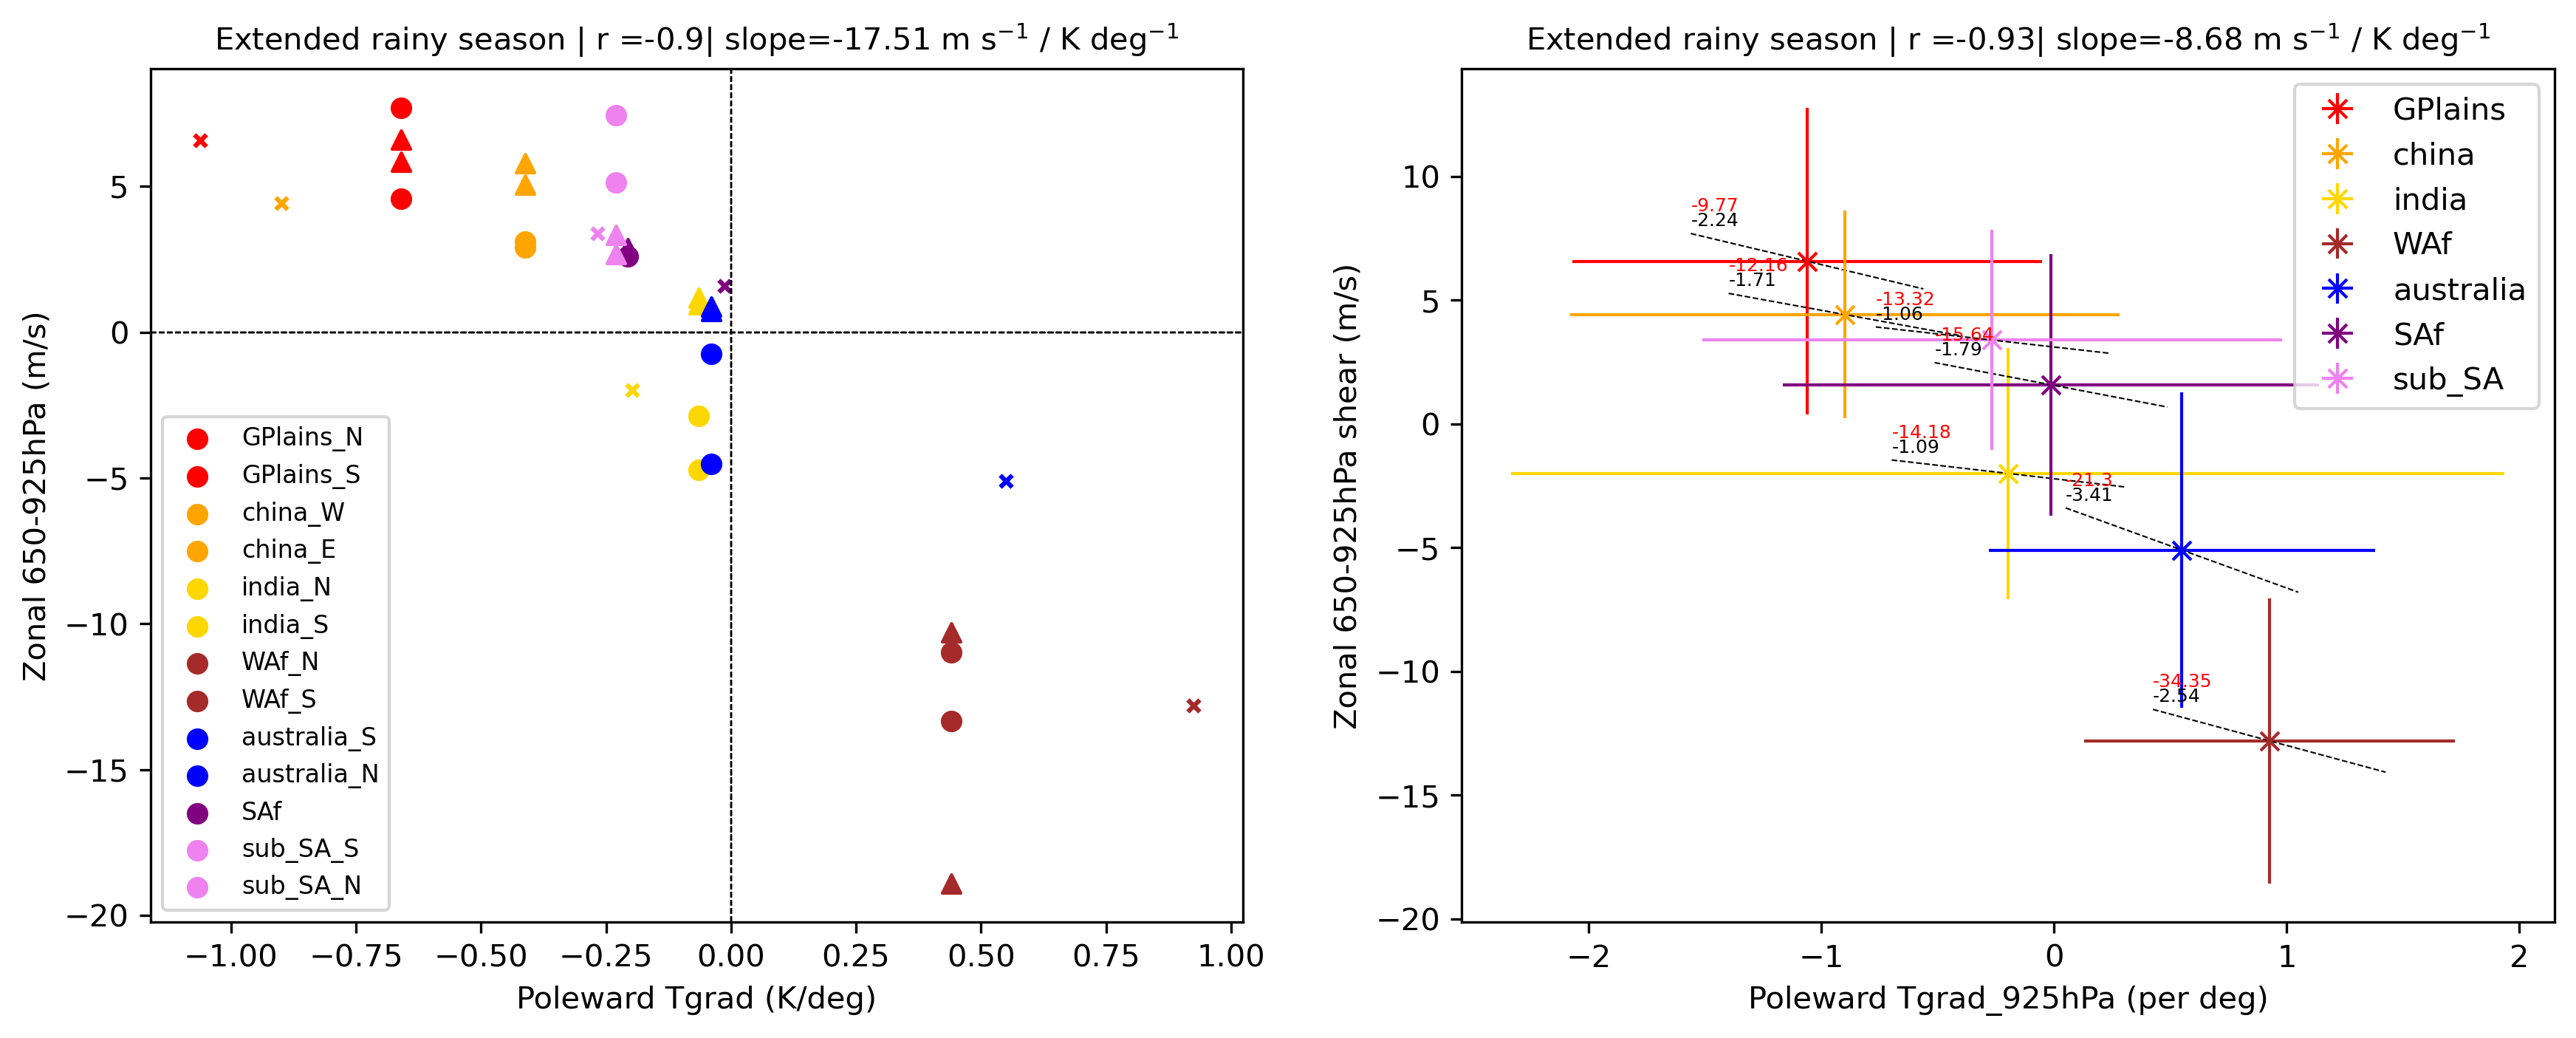

In [85]:
f = plt.figure(figsize=(14,5), dpi=300)

colors = ['red','red', 'orange', 'orange', 'gold', 'gold', 'brown', 'brown', 'blue', 'blue', 'purple','violet', 'violet']
lss = ['solid', 'solid', 'solid', 'solid', 'dashed', 'dashed', 'dashed']

deg = 111 #km

# for idx, seas in enumerate(['MAM', 'JJA', 'SON', 'DJF']):

tgrad_list = []
shear_list = []
ax = f.add_subplot(121)
for ids, reg in enumerate((list(MREGIONS.keys()))):
    
        

        seas = MREGIONS[reg][9]

        box = MREGIONS[reg][6]
        lbox = MREGIONS[reg][0]
        
        lat = np.mean(box[2:4])

        erashear_box = era_ushear.sel(month=era_ushear.month.isin(seas), latitude=slice(box[2],box[3]), longitude=slice(box[0],box[1])).mean(['month','longitude','latitude']).squeeze()
        erathick_box = era_thick.sel(month=era_ushear.month.isin(seas), latitude=slice(box[2],box[3]), longitude=slice(box[0],box[1])).mean(['month','longitude','latitude']).squeeze()
        erathick_box = erathick_box/default.g
        erat_box = t2.sel(month=t2.month.isin(seas), latitude=slice(lbox[2],lbox[3]), longitude=slice(lbox[0],lbox[1])).mean(['month','longitude','latitude']).squeeze()
        erat_poly = t2.sel(month=t2.month.isin(seas), latitude=slice(lbox[2],lbox[3]), longitude=slice(lbox[0],lbox[1])).mean(['month','longitude']).squeeze().polyfit(dim='latitude', deg=1)
        
        coriolis = basic.coriolis_parameter(lat* units.degrees) # coriolis  du/dz = -(g/f) * dT/dy zonal thermal wind
        rossby_def_radius = (default.g / coriolis)*-1
        
        shear_theoretical = (erat_poly['polyfit_coefficients'][0] / 111 * rossby_def_radius/1000 / erat_box * erathick_box).values
        
        if ids >= 8:
            erat_poly = erat_poly*-1

#         if ids >= 8:
#             erashear_box = erashear_box*-1

        print(reg, erathick_box)

        ax.scatter(erat_poly['polyfit_coefficients'][0], erashear_box, label=reg, c=colors[ids])
        
        ax.scatter(erat_poly['polyfit_coefficients'][0], shear_theoretical, c=colors[ids], marker='^')
        
        
        plt.title('Rainy season per region (DJF or JJA)', fontsize=10)
        ax.set_xlabel('Poleward Tgrad (K/deg)')
        ax.set_ylabel('Zonal 650-925hPa (m/s)')
        ax.axhline(0, color='k', linestyle='dashed', linewidth=0.5)
        ax.axvline(0, color='k', linestyle='dashed', linewidth=0.5)
        tgrad_list.append(erat_poly['polyfit_coefficients'][0].values)
        shear_list.append(erashear_box.values)
pf, intercept, rval, p, std_err = stats.linregress(tgrad_list, shear_list)
plt.title('Extended rainy season | r ='+ str(np.round(rval,2))+'| slope='+str(np.round(pf,2))+' m s$^{-1}$ / K deg$^{-1}$', fontsize=10)  
ax.legend(loc='lower left', fontsize=8)

colors = ['red', 'orange', 'gold', 'brown', 'blue', 'purple', 'violet']
tgrad_list = []
shear_list = []
for ids, regs in enumerate(MMREGIONS.keys()):
    var2 = 'ushear925_650'
    var1 = 'tgrad2m'
    
    dat = rdics[regs]
    
    x = dat[var1]
    y = dat[var2]


    if ids >= 4:
        x = x*-1
        
    #ax.set_ylim(-1.5,1.5)
        
    ax.scatter(np.mean(x), np.mean(y), color=colors[ids], marker='x', s=15)

ax = f.add_subplot(122)
colors = ['red', 'orange', 'gold', 'brown', 'blue', 'purple', 'violet']
tgrad_list = []
shear_list = []
for ids, regs in enumerate(MMREGIONS.keys()):
    var2 = 'ushear925_650'
    var1 = 'tgrad2m'
    
    dat = rdics[regs]
    
    x = dat[var1]
    y = dat[var2]
    #ipdb.set_trace()
    #theoretical_y = (x / 111 * rossby_def_radius/1000 / dat['t925'] * erathick_box.values).values
    theoretical_y = []
    for case in np.arange(len(dat['tminlat'])):
       # ipdb.set_trace()
        coriolis = basic.coriolis_parameter(dat['tminlat'].values[case]* units.degrees)
        rossby_def_radius = (default.g / coriolis)*-1
        valout = np.array(dat[var1].values[case] / 111 * rossby_def_radius/1000 / dat['t925'].values[case] * erathick_box.values)

        theoretical_y.append(float(valout))
    #mean:
#     coriolis = basic.coriolis_parameter(np.mean(dat['tminlat'])* units.degrees) # coriolis  du/dz = -(g/f) * dT/dy zonal thermal wind
#     rossby_def_radius = (default.g / coriolis)*-1
#     theoretical_y = (np.mean(x) / 111 * rossby_def_radius/1000 / np.mean(dat['t925']) * erathick_box.values)
    #ipdb.set_trace()
    if ids >= 4:
        x = x*-1
        
    #ax.set_ylim(-1.5,1.5)
        
    ax.scatter(np.mean(x), np.mean(y), color=colors[ids], marker='', s=1)
    plt.errorbar(np.mean(x), np.mean(y), yerr=np.std(y), xerr=np.std(x), fmt="x", color=colors[ids], linewidth=1, label=regs)
    pf, intercept, rval, p, std_err = stats.linregress(x, y)
    
    pf_theo, intercept_theo, rval_theo, p_theo, std_err_theo = stats.linregress(x, theoretical_y)
    
    xer = np.arange(np.mean(x)-0.5,np.mean(x)+1) #np.arange(np.percentile(x,0.4), np.percentile(x,0.6))
    yer = intercept+pf*xer
    yer_theo = intercept_theo+pf_theo*xer
    plt.plot(xer, yer, color='k', linestyle='dashed', linewidth=0.5)
    
    #plt.plot(xer,yer_theo, color='r', linestyle='dashed', linewidth=0.5)
    
    
    plt.text(xer[0], yer[0]+0.3, str(np.round(pf,2)), fontsize=6)
    plt.text(xer[0], yer[0]+0.9, str(np.round(pf_theo,2)), fontsize=6, color='r')
    tgrad_list.append(np.mean(x))
    shear_list.append(np.mean(y))
    ax.set_xlabel('Poleward Tgrad_925hPa (per deg)')
    ax.set_ylabel('Zonal 650-925hPa shear (m/s)')
pf, intercept, rval, p, std_err = stats.linregress(tgrad_list, shear_list)
plt.title('Extended rainy season | r ='+ str(np.round(rval,2))+'| slope='+str(np.round(pf,2))+' m s$^{-1}$ / K deg$^{-1}$', fontsize=10)
plt.legend()
#f.savefig('/home/ck/DIR/cornkle/figs/LMCS/CMIP_LS3MIP/ERA5_only/ERA5_scatter_meansVs_MCSdays.png')

In [47]:
import matplotlib.patches as patches
def draw_map(ax, t, lat, lon, title='', levels=None, quiver=None, contour=None, clabel='', cmap='RdBu_r'):
   
    plt.contourf(lon, lat, t, transform=ccrs.PlateCarree(), cmap=cmap, levels=levels, extend='both')
    ax.coastlines()

    ## quiver list
    if quiver is not None:
        qu = ax.quiver(quiver['x'], quiver['y'], quiver['u'], quiver['v'],scale=quiver['scale'],width=0.0005, headwidth=7)
    
    
        ## additional contour on plot   
    if contour is not None:
        contours = ax.contour(contour['x'], contour['y'], contour['data'], levels=contour['levels'], colors='Turquoise', linewidths=0.5 )
        #plt.clabel(contours, inline=True, fontsize=7, fmt='%1.1f')
    
    # Gridlines
    xl = ax.gridlines(draw_labels=True);
    xl.top_labels = False
    xl.right_labels = False
    xl.xlines = False
    xl.ylines=False
    # Countries
    ax.add_feature(cartopy.feature.BORDERS, linestyle='--', color='grey');
    
    #rect2 = patches.Rectangle((box[0],box[2]),box[1]-box[0],box[3]-box[2],linewidth=0.8,edgecolor='w',facecolor='none', zorder=99)
        
    #ax.add_patch(rect2)
    
    plt.title(title)
    cbar = plt.colorbar()
    cbar.set_label(clabel)

/home/ck/miniconda3/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


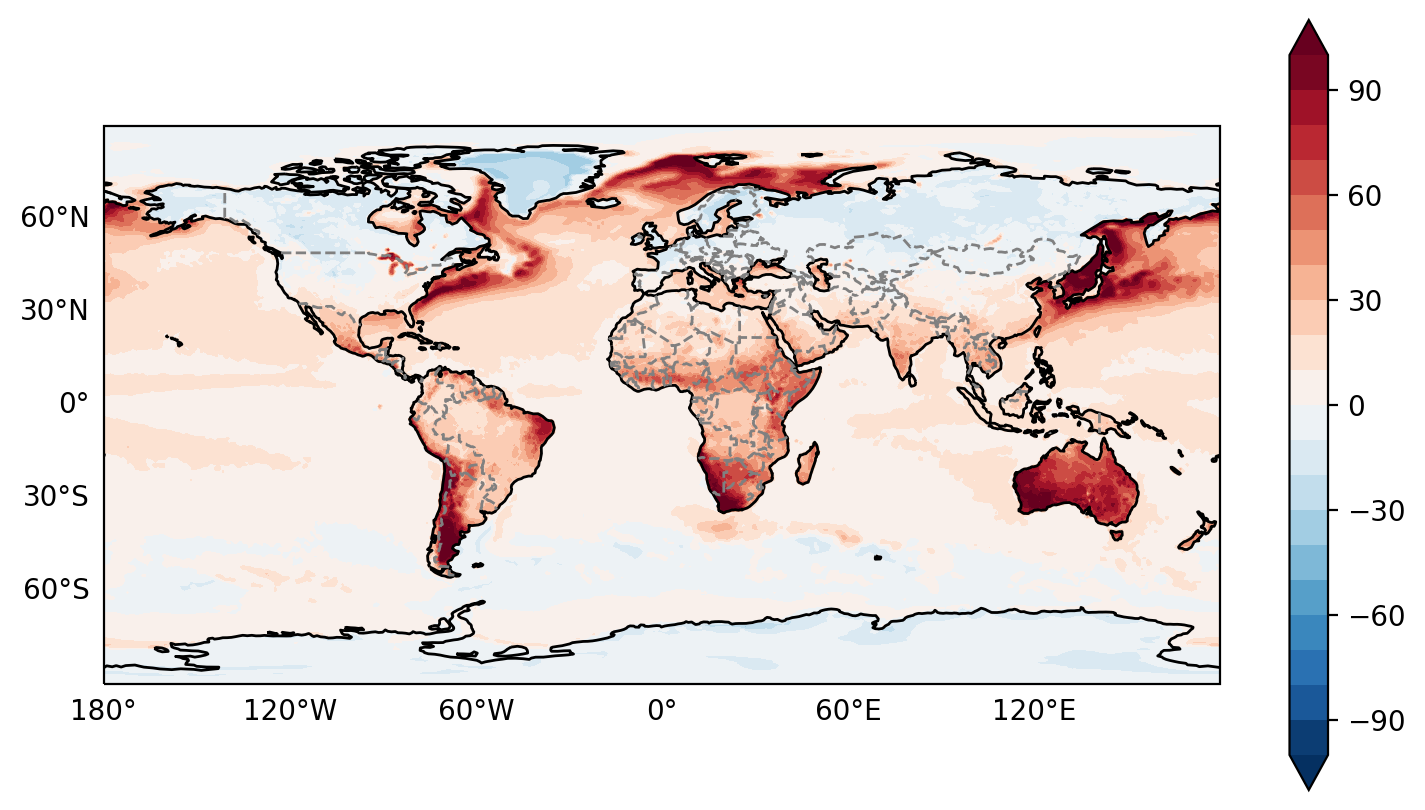

In [73]:
f = plt.figure(figsize=(9,5), dpi=200)
ax = f.add_subplot(111, projection=ccrs.PlateCarree())
draw_map(ax, sh.sel(month=12), sh.latitude, sh.longitude, levels=np.arange(-100,101,10))

In [11]:
era_uh = era5f_pl['u'].sel(level=650).groupby('time.season').mean('time').load()
era_ul = era5f_pl['u'].sel(level=925).groupby('time.season').mean('time').load()
era_vh = era5f_pl['v'].sel(level=650).groupby('time.season').mean('time').load()
era_vl = era5f_pl['v'].sel(level=925).groupby('time.season').mean('time').load()
era_t = era5f_pl['t'].sel(level=925).groupby('time.season').mean('time').load()

era_ushear = era_uh-era_ul
era_vshear = era_vh-era_vl
era_shear = np.sqrt(era_ushear**2+era_vshear**2)

In [21]:
era_uhh = era5f_pl['u'].sel(level=400).groupby('time.season').mean('time').load()
era_vhh = era5f_pl['v'].sel(level=400).groupby('time.season').mean('time').load()

In [13]:
era5f_srfc = xr.open_mfdataset('/media/ck/LStorage/global_water/other/ERA5_global_0.7/monthly/surface/*.nc')
era5f_srfc = u_darrays.flip_lat(era5f_srfc)

OSError: no files to open

In [141]:
era5_sm = era5f_srfc['swvl1'].groupby('time.season').mean('time').load()
era5_sshf = era5f_srfc['sshf'].groupby('time.season').mean('time').load()
era5_slhf = era5f_srfc['slhf'].groupby('time.season').mean('time').load()